In [2]:
import torch
import os
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from floorplans.lidar.lidar import Lidar2D, OnlineTrajectoryLidarDataset
import glob
import numpy as np
import matplotlib.cm as cm
import networkx as nx

In [11]:
results_dir = "../../results/2021-10-08_12-09_dist_online_dense_anim"
results = torch.load(os.path.join(results_dir, "dinno_results.pt"), map_location=torch.device("cpu"))

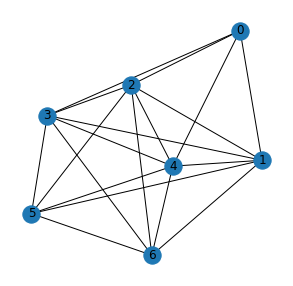

In [13]:
(fig, ax) = plt.subplots(figsize=(5, 5))
nx.draw_kamada_kawai(results["current_graph"][1], with_labels=True)

In [3]:
results_dir = "../../results/2021-10-08_12-09_dist_online_dense_anim"
results = torch.load(os.path.join(results_dir, "dinno_results.pt"), map_location=torch.device("cpu"))

vloss = torch.stack(results["validation_loss"])
mean_vl = torch.mean(vloss, dim=1)
mean_vl


tensor([17.3581,  4.8585,  4.8300,  4.8011,  4.7888,  4.7594,  4.7699,  4.7320,
         4.6939,  4.7160,  4.6575,  4.6858,  4.6179,  4.5888,  4.5618,  4.5340,
         4.5602,  4.5541,  4.5577,  4.5275,  4.4491,  4.4555,  4.4503,  4.4373,
         4.4169,  4.4136,  4.4365,  4.3944,  4.4259,  4.4100,  4.4359,  4.4461,
         4.3712,  4.4010,  4.4360,  4.4005,  4.3502,  4.3694,  4.4041,  4.3064,
         4.3509,  4.2585,  4.2982,  4.2152,  4.2242,  4.2332,  4.1932,  4.1461,
         4.1572,  4.1840,  4.2088,  4.2219,  4.1769,  4.1036,  4.2560,  4.0504,
         4.0233,  4.0742,  3.9883,  4.1701,  4.0842,  4.1002,  4.1263,  3.8801,
         3.8579,  3.8634,  4.0090,  4.1509,  3.9172,  3.8639,  3.9226,  4.0217,
         4.0875,  3.8842,  3.9800,  3.8488,  4.0354,  3.9682,  4.0263,  3.9002,
         4.0020,  4.0141,  3.8947,  4.0980,  3.7462,  3.6710,  3.7439,  3.6949,
         3.7639,  3.7315,  3.6698,  3.6392,  3.6545,  3.6772,  3.5505,  3.7479,
         3.6526,  3.7220,  3.6635,  3.74

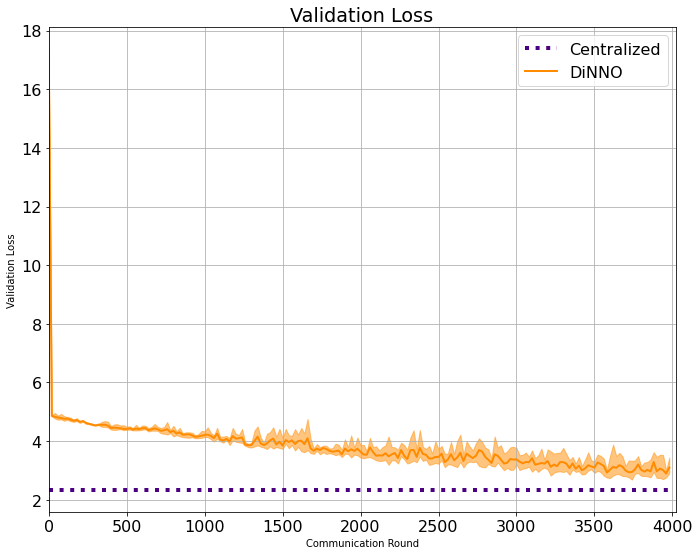

In [4]:
(fig, ax) = plt.subplots(tight_layout=True, figsize=(10, 8))
plt.rcParams.update({'font.size': 16})

ax.set_title("Validation Loss")

acc = torch.stack(results["validation_loss"])
num_frames = len(results["validation_loss"])

mean_acc = torch.mean(acc, dim=1)
lb = torch.amin(acc, dim=1) 
ub = torch.amax(acc, dim=1) 
t = torch.arange(mean_acc.shape[0]) * 20
ax.plot(t, 2.34 * torch.ones_like(t), linestyle=":",linewidth=4, color="indigo", label="Centralized")
lmean = ax.plot(0, mean_acc[0], linewidth=2, c="darkorange", label="DiNNO")
fb = ax.fill_between(t[:1], lb[:1], ub[:1], color="darkorange", alpha=0.5)
ax.legend(loc=4)
ax.set_ylim([0, 1])
ax.set_xlim([0, num_frames*20])
ax.grid()

def update_valplot(i):
    ax.cla()
    ax.set_title("Validation Loss")
    ax.plot(t, 2.34 * torch.ones_like(t), linestyle=":",linewidth=4, color="indigo", label="Centralized")
    ax.plot(t[:i], mean_acc[:i], linewidth=2, c="darkorange", label="DiNNO")
    ax.fill_between(t[:i], lb[:i], ub[:i], color="darkorange", alpha=0.5)
    ax.legend()
    ax.set_xlim([0, num_frames*20])
    ax.set_ylabel("Validation Loss")
    ax.set_xlabel("Communication Round")
    ax.grid()

valanim = anim.FuncAnimation(fig, update_valplot, frames=num_frames)
valanim.save("dens_vids/val.mp4", dpi=300, fps=15, bitrate=3000)

In [4]:
class GraphTrajAnim:
    def __init__(self):
        self.colors = list(cm.get_cmap("Dark2").colors)
        self.colors[0] = "orangered"

        self.fig, self.ax = plt.subplots(figsize=(10,7), tight_layout=True)
        # Initialize datasets and lidar
        # Load the data
        # Settings
        data_dir = "../../floorplans/32_data"
        waypoint_subdir = "tight_paths"
        img_path = os.path.join(data_dir, "floor_img.png")
        num_beams = 20
        beam_samps = 25
        beam_length = 0.2
        spline_res = 30
        samp_distribution_factor = 1.0
        collision_samps = 50
        fine_samps = 3
        num_scans_in_window = 30
        spline_res = 10
        
        # Setup Lidar Object
        lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps,
            samp_distribution_factor, collision_samps, fine_samps, border_width=30)
        
        # Waypoint Settings
        wp_names = glob.glob1(os.path.join(data_dir, waypoint_subdir), "*.npy") 
        
        datasets = []
        for wp_name in wp_names:
            wp_path = os.path.join(data_dir, waypoint_subdir, wp_name)
            wps = np.load(wp_path)
            ds = OnlineTrajectoryLidarDataset(lidar, wps, 
                spline_res, num_scans_in_window)
            datasets.append(ds)

        results_dir = "../../results/2021-10-08_12-09_dist_online_dense_anim"
        self.results = torch.load(os.path.join(results_dir, "dinno_results.pt"), map_location=torch.device("cpu"))
        self.N = 7
        
        self.datasets = datasets
        self.lidar = lidar

        num_frames = len(self.results["current_position"])
        
        self.traj_anim = anim.FuncAnimation(self.fig, self.draw, init_func=self.init_map, frames=num_frames, blit=True)

    def init_map(self):
        # Draw Map
        X, Y = np.meshgrid(self.lidar.xs, self.lidar.ys)
        self.ax.contourf(X, Y, self.lidar.img, cmap=cm.binary, zorder=0)
    
        # Draw trajectories    
        for i in range(len(self.datasets)):
            self.ax.plot(self.datasets[i].scan_locs[:, 0], self.datasets[i].scan_locs[:, 1], zorder=0, c=self.colors[i])
    
        dot_size = 60
        self.all_artists = []
        self.scat_artists = []
        poses = self.results["current_position"][0]
        for i in range(len(self.datasets)):
            scat = self.ax.scatter(poses[i, 0], poses[i, 1], s=dot_size, color="None", zorder=3)
            self.scat_artists.append(scat)
            self.all_artists.append(scat)
        
        self.complete_graph = nx.complete_graph(self.N)
        self.edge_artists = []
        
        for edge in self.complete_graph.edges():
            pose1 = poses[edge[0], :].reshape(1, -1)
            pose2 = poses[edge[1], :].reshape(1, -1)
            edge_poses = np.vstack((pose1, pose2))
            line = self.ax.plot(edge_poses[:, 0], edge_poses[:, 1], c="black", linewidth=0, linestyle=":", zorder=2)
            self.edge_artists.append(line[0])
            self.all_artists.append(line[0])
         
        return self.all_artists 
    
    def draw(self, t):    
        robo_poses = self.results["current_position"][t]
        self.update_robots(robo_poses)
        self.update_graph(t)
        return self.all_artists

    def update_robots(self, poses):
        for i in range(len(self.datasets)):
            self.scat_artists[i].set_offsets(poses[i, :])
            self.scat_artists[i].set_color(self.colors[i])
    
    def update_graph(self, t):
        poses = self.results["current_position"][t]
        eind = 0
        for edge in self.complete_graph.edges():
            if edge in self.results["current_graph"][t].edges():
                pose1 = poses[edge[0], :].reshape(1, -1)
                pose2 = poses[edge[1], :].reshape(1, -1)
                edge_poses = np.vstack((pose1, pose2))
                self.edge_artists[eind].set_linewidth(2)
                self.edge_artists[eind].set_xdata(edge_poses[:, 0])
                self.edge_artists[eind].set_ydata(edge_poses[:, 1])
            else:
                self.edge_artists[eind].set_linewidth(0)
            eind += 1
    
    def run(self):
        self.traj_anim.save("dens_vids/graphtraj.mp4", dpi=500, fps=15, bitrate=6000)


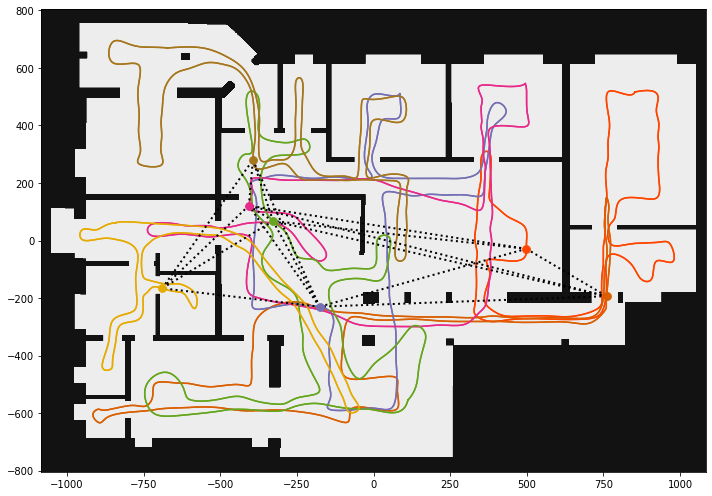

In [5]:
tanim = GraphTrajAnim()
tanim.run()

In [ ]:
class LidarTrajAnim:
    def __init__(self):
        self.colors = list(cm.get_cmap("Dark2").colors)
        self.colors[0] = "orangered"

        self.fig, self.ax = plt.subplots(figsize=(10,7), tight_layout=True)
        # Initialize datasets and lidar
        # Load the data
        # Settings
        data_dir = "../../floorplans/32_data"
        waypoint_subdir = "tight_paths"
        img_path = os.path.join(data_dir, "floor_img.png")
        num_beams = 20
        beam_samps = 25
        beam_length = 0.2
        spline_res = 30
        samp_distribution_factor = 1.0
        collision_samps = 50
        fine_samps = 3
        num_scans_in_window = 30
        spline_res = 10
        
        # Setup Lidar Object
        lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps,
            samp_distribution_factor, collision_samps, fine_samps, border_width=30)
        
        # Waypoint Settings
        wp_names = glob.glob1(os.path.join(data_dir, waypoint_subdir), "*.npy") 
        
        datasets = []
        for wp_name in wp_names:
            wp_path = os.path.join(data_dir, waypoint_subdir, wp_name)
            wps = np.load(wp_path)
            ds = OnlineTrajectoryLidarDataset(lidar, wps, 
                spline_res, num_scans_in_window)
            datasets.append(ds)
        
        self.datasets = datasets
        self.lidar = lidar
        self.speedup_factor = 3
        frame_lens = [int(ds.scan_locs.shape[0] / self.speedup_factor) for ds in self.datasets]
        num_frames = min(frame_lens)
        
        self.traj_anim = anim.FuncAnimation(self.fig, self.draw, init_func=self.init_map, frames=num_frames, blit=True)

    def init_map(self):
        # Draw Map
        X, Y = np.meshgrid(self.lidar.xs, self.lidar.ys)
        self.ax.contourf(X, Y, self.lidar.img, cmap=cm.binary, zorder=0)
    
        # Draw trajectories    
        for i in range(1, len(self.datasets)):
            self.ax.plot(self.datasets[i].scan_locs[:, 0], self.datasets[i].scan_locs[:, 1], alpha=0.3, zorder=0, c=self.colors[i])
        self.ax.plot(self.datasets[0].scan_locs[:, 0], self.datasets[0].scan_locs[:, 1], c=self.colors[0], linewidth=2, zorder=3)
    
        dot_size = 60
        scats = []
        poses = self.get_poses(0)
        for i in range(len(self.datasets)):
            if i == 0:
                alpha = 1.0
            else:
                alpha = 0.4
            scat = self.ax.scatter(poses[i, 0], poses[i, 1], s=dot_size, color="None", alpha=alpha, zorder=3)
            scats.append(scat)
        
        scan_points = self.lidar.scan(poses[0, :].reshape(1, -1))
        scan_points[:, 2] = np.rint(scan_points[:, 2])
        ld_points = scan_points[scan_points[:, 2] != 1.0]
        hd_points = scan_points[scan_points[:, 2] == 1.0]
        self.ld_scat = self.ax.scatter(ld_points[:, 0], ld_points[:, 1], s=5, color="None", alpha=0.4, zorder=2)
        self.hd_scat = self.ax.scatter(hd_points[:, 0], hd_points[:, 1], s=15, color="None", alpha=1.0, zorder=2)
        scats.append(self.ld_scat)
        scats.append(self.hd_scat)
        
        self.scats = scats
        
        return self.scats 
    
    def draw(self, t):    
        robo_poses = self.get_poses(self.speedup_factor * t)
        self.update_lidar(robo_poses[0, :].reshape(1, -1))
        self.update_robots(robo_poses)
        return self.scats
    
    def update_lidar(self, pos):
        scan_points = self.lidar.scan(pos)
        scan_points[:, 2] = np.rint(scan_points[:, 2])
        ld_points = scan_points[scan_points[:, 2] != 1.0]
        hd_points = scan_points[scan_points[:, 2] == 1.0]
        self.ld_scat.set_offsets(ld_points[:, :2])
        self.hd_scat.set_offsets(hd_points[:, :2])
        self.ld_scat.set_color("darkblue")
        self.hd_scat.set_color("gold")
    
    def update_robots(self, poses):
        for i in range(len(self.datasets)):
            self.scats[i].set_offsets(poses[i, :])
            self.scats[i].set_color(self.colors[i])
    
    def get_poses(self, t):
        poses = [ds.scan_locs[t, :].reshape(1, -1) for ds in self.datasets]
        return np.vstack(poses)
    
    def run(self):
        self.traj_anim.save("dens_vids/lidartraj.mp4", dpi=500, fps=30, bitrate=6000)


In [ ]:
#tanim = LidarTrajAnim()
#tanim.run()

In [9]:
class MeshAnimation:
    def __init__(self, agent):
        self.colors = list(cm.get_cmap("Dark2").colors)
        self.colors[0] = "orangered"

        self.fig, self.ax = plt.subplots(figsize=(10,7), tight_layout=True)
        
        results_dir = "../../results/2021-10-08_12-09_dist_online_dense_anim"
        results = torch.load(os.path.join(results_dir, "dinno_results.pt"), map_location=torch.device("cpu"))
        
        self.meshes = results["mesh_grid_density"]
        self.X = results["mesh_inputs"][:, 0]
        self.Y = results["mesh_inputs"][:, 1]
        self.agent = agent

        # Initialize datasets and lidar
        # Load the data
        # Settings
        data_dir = "../../floorplans/32_data"
        waypoint_subdir = "tight_paths"
        img_path = os.path.join(data_dir, "floor_img.png")
        num_beams = 20
        beam_samps = 25
        beam_length = 0.2
        spline_res = 30
        samp_distribution_factor = 1.0
        collision_samps = 50
        fine_samps = 3
        num_scans_in_window = 30
        spline_res = 10
        
        # Setup Lidar Object
        lidar = Lidar2D(img_path, num_beams, beam_length, beam_samps,
            samp_distribution_factor, collision_samps, fine_samps, border_width=30)
        
        # Waypoint Settings
        wp_names = glob.glob1(os.path.join(data_dir, waypoint_subdir), "*.npy") 
        
        wp_path = os.path.join(data_dir, waypoint_subdir, wp_names[agent])
        wps = np.load(wp_path)
        self.dataset = OnlineTrajectoryLidarDataset(lidar, wps, 
            spline_res, num_scans_in_window)
        
        num_frames = len(self.meshes)
        self.poses = [results["current_position"][t][self.agent, :].reshape(1, -1) for t in range(num_frames)]
        self.poses = np.vstack(self.poses)
        
        #print(self.poses)
        
        self.mesh_anim = anim.FuncAnimation(self.fig, self.draw, frames=num_frames)

    def init_map(self):
        return self.trif,
    
    def draw(self, t):
        self.ax.cla()
        #self.ax.plot(self.poses[:, 0], self.poses[:, 1], color=self.colors[self.agent], zorder=3)
        self.ax.plot(self.dataset.scan_locs[:, 0], self.dataset.scan_locs[:, 1], c=self.colors[self.agent], linewidth=2, zorder=3)
        self.ax.scatter(self.poses[t, 0], self.poses[t, 1], color=self.colors[self.agent], s=100, zorder=3)
        self.trif = self.ax.tricontourf(self.X, self.Y, self.meshes[t][self.agent, :, :].reshape(-1))
        return #self.trif,
    
    def run(self):
        self.mesh_anim.save("dens_vids/mesh{}.mp4".format(self.agent), dpi=500, fps=15, bitrate=6000)


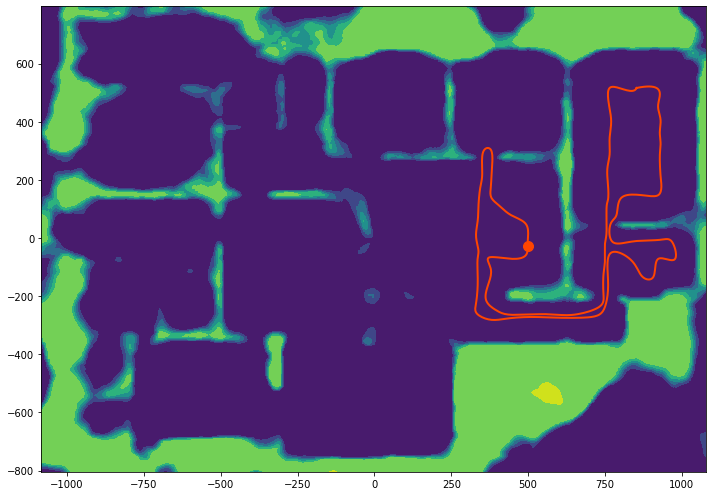

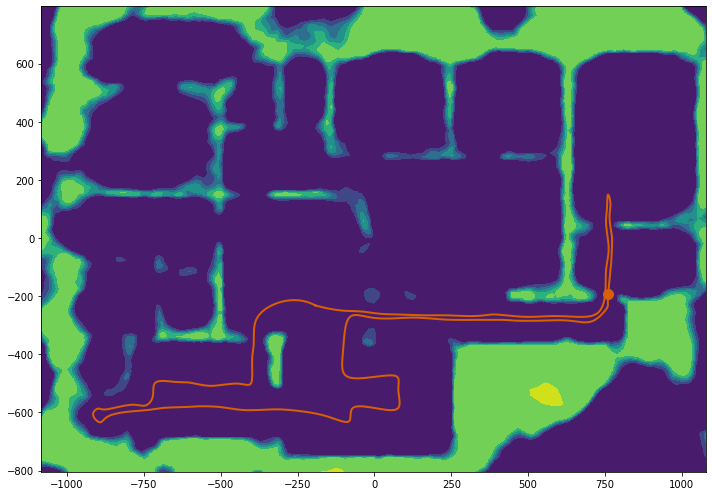

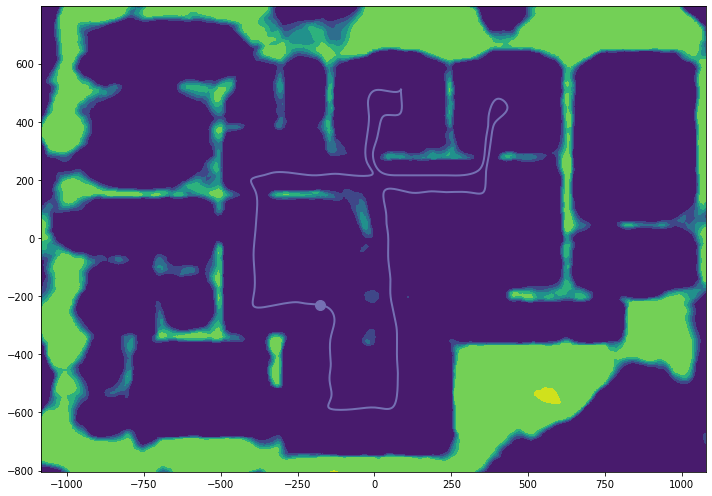

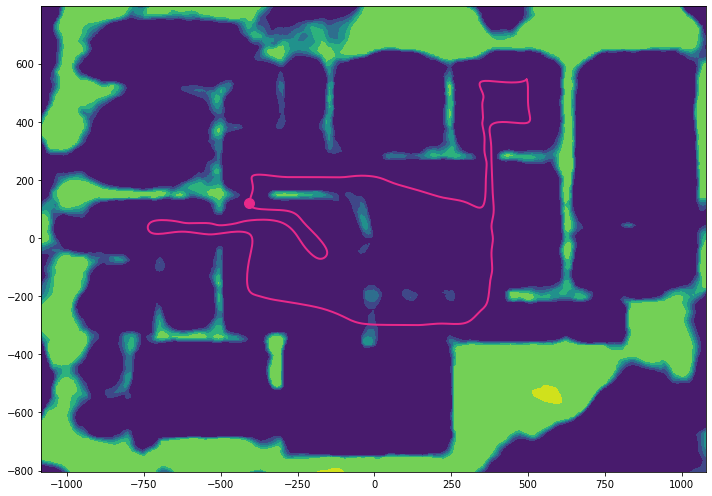

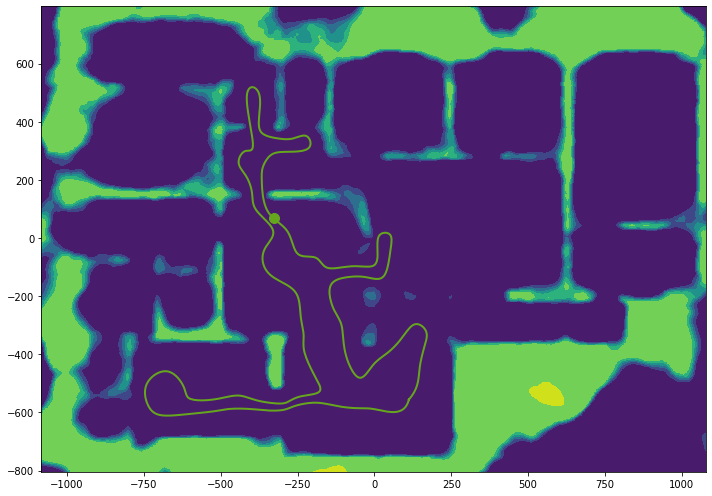

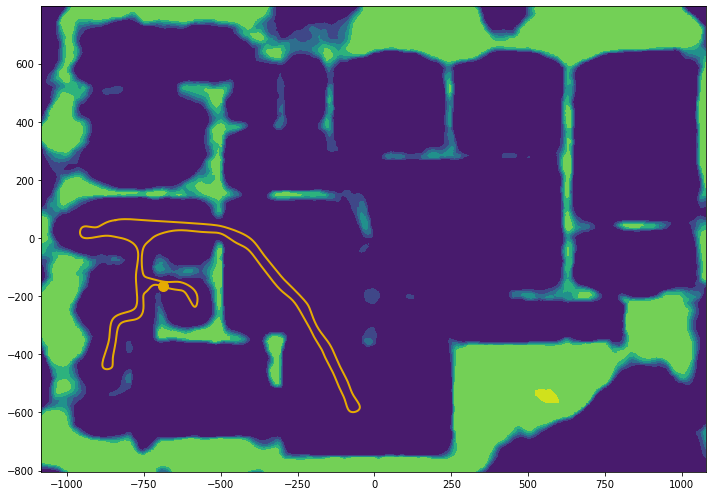

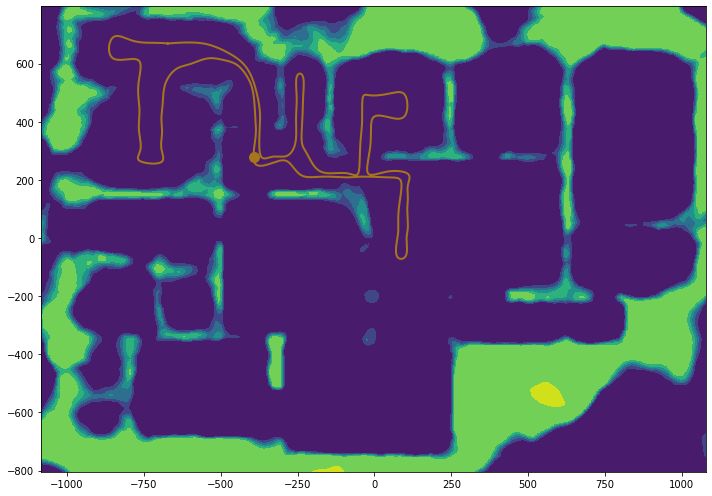

In [10]:
for i in range(7):
    meshanim = MeshAnimation(i)
    meshanim.run()